<a href="https://colab.research.google.com/github/dcerdac/MachineLearningProjects/blob/master/Multiclass_Denbury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.28.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.29.2
    Uninstalling transformers-4.29.2:
      Successfully uninstalled transformers-4.29.2


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
df=pd.read_csv('gdrive/My Drive/DailySummaryDHFTubing2018-2022.csv')


In [4]:
df.columns = ['well_name', 'api_uwi', 'region', 'field_name', 'secondary_job_type',
'job_start_date', 'total_number_of_reports', 'report_number', 'job_day',
'report_start_date', 'daily_field_est_total', 'total_field_estimate',
'total_final_invoice', 'comment', 'idrec']

In [5]:
# Create a 'label' column with consecutive numbers within each group in the 'API/UWI' column
df['label'] = df.groupby('idrec')['job_day'].rank(method='dense').astype(int)

# Identify the last day of each group in the 'API/UWI' column and set the value to 'last day'
df.loc[df.groupby('idrec')['job_day'].idxmax(), 'label'] = 'last day'

df['label'] = df['label'].astype(str)


In [6]:
df= df[df.label.isin(['1','2','3','4','5','6','last day'])]

In [7]:
data = df[['label', 'comment']]
print("Original: ", data.shape)
data.dropna(inplace=True)
print("Final: ", data.shape)

data.sample(5)

Original:  (3612, 2)
Final:  (3612, 2)


<ipython-input-7-536dbe82d153>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


,label,comment
1521,4,"Held safety meeting, unloaded new white band t..."
3645,5,7 am start up and safety meeting. Continue pi...
2529,1,"11:00 JSA and move to location, spot in and le..."
958,3,HSM & Review JSA. OWU. Bleed off well. RU TUBO...
3134,2,"7:00 Start & warm rig, JSA MTG, BWO, Rig up, H..."


In [11]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments


In [10]:
!pip install --upgrade accelerate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 9.1 MB/s eta 0:00:00


# Code

In [12]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
)

NameError: ignored

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load data
# Encode labels
data['label'] = pd.Categorical(data['label'])
data['encoded_label'] = data['label'].cat.codes

# Split data into train and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Load tokenizer and tokenize the comments
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(df):
    return tokenizer(
        df['comment'].tolist(),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

train_encodings = tokenize(train_df)
test_encodings = tokenize(test_df)


import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_df['encoded_label'].tolist())
test_dataset = Dataset(test_encodings, test_df['encoded_label'].tolist())


# Load the pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(data['label'].cat.categories))

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
)

from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits_tensor = torch.tensor(logits)
    predictions = torch.argmax(logits_tensor, dim=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)



<ipython-input-13-fdb678c16972>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = pd.Categorical(data['label'])
<ipython-input-13-fdb678c16972>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['encoded_label'] = data['label'].cat.codes


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

NameError: ignored

<ipython-input-8-fdb678c16972>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


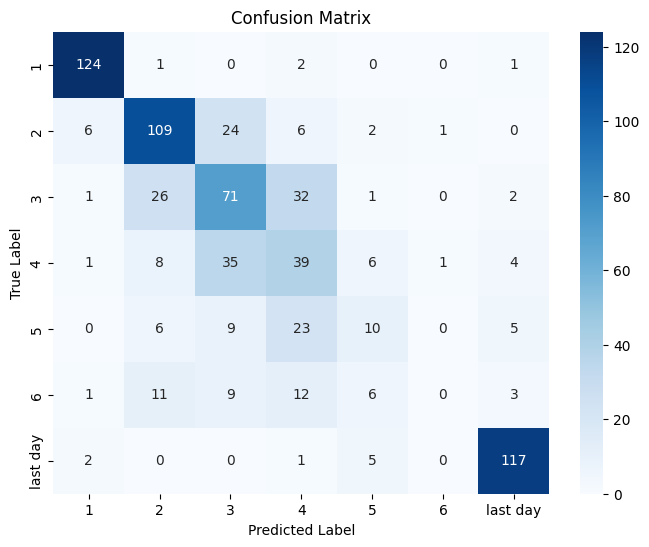

Accuracy: 65.01%


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_metrics_and_get_predictions(predictions, labels):
    logits_tensor = torch.tensor(predictions)
    predictions = torch.argmax(logits_tensor, dim=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "predictions": predictions}

# Get evaluation predictions and labels
predictions, labels, _ = trainer.predict(test_dataset)
metrics = compute_metrics_and_get_predictions(predictions, labels)

# Calculate the confusion matrix
cm = confusion_matrix(labels, metrics["predictions"])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data['label'].cat.categories, yticklabels=data['label'].cat.categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the accuracy as a percentage
accuracy_percentage = metrics['accuracy'] * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

In [ ]:
# Save the trained model
model_save_path = './multiclass_classifier_model'
tokenizer_save_path = './multiclass_classifier_tokenizer'

model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)


('./multiclass_classifier_tokenizer/tokenizer_config.json',
 './multiclass_classifier_tokenizer/special_tokens_map.json',
 './multiclass_classifier_tokenizer/vocab.txt',
 './multiclass_classifier_tokenizer/added_tokens.json')

In [ ]:
# Load the saved model
model = DistilBertForSequenceClassification.from_pretrained(model_save_path)

# Load the saved tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_save_path)


NameError: ignored

# Prediction

In [ ]:
def predict(text, model, tokenizer, label_categories):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=-1)
    likelihoods = {label_categories[i]: round(prob.item() * 100, 2) for i, prob in enumerate(probabilities[0])}
    return likelihoods
label_categories = data['label'].cat.categories.tolist()


# New Section

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch.nn.functional as F

# Load the saved model
model_path = './multiclass_classifier_model'
loaded_model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Load the saved tokenizer
tokenizer_path = './multiclass_classifier_tokenizer'
loaded_tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)

def predict(text, model, tokenizer, label_categories):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=-1)
    likelihoods = {label_categories[i]: round(prob.item() * 100, 2) for i, prob in enumerate(probabilities[0])}
    return likelihoods

# Define the label categories
label_categories = data['label'].cat.categories.tolist()

# Make a prediction on a new data entry
new_data_entry = '''7:00 s & s rig. safety mtg. 0psi- tbg. bwo. l.d. polish rod. prep to pull  rods. pooh w/ 15-1" rods. shut down due to high winds. burning threads.  swifn. 9:30'''
likelihoods = predict(new_data_entry, loaded_model, loaded_tokenizer, label_categories)
print(likelihoods)



{'1': 0.53, '2': 19.04, '3': 23.42, '4': 26.95, '5': 13.72, '6': 15.79, 'last day': 0.55}


In [ ]:
predictions, true_labels, _ = trainer.predict(test_dataset)
def labels_to_categories(label_indices, label_categories):
    return [label_categories[i] for i in label_indices]
# Get true labels and predicted labels from the evaluation dataset
true_labels = test_df['encoded_label'].tolist()
predicted_labels = np.argmax(predictions, axis=1)

# Find the indices of the misclassified entries
misclassified_indices = np.where(true_labels != predicted_labels)[0]

# Get the misclassified entries from the original dataframe and add the decoded predicted labels
misclassified_entries = test_df.iloc[misclassified_indices].copy()
decoded_predicted_labels = labels_to_categories(predicted_labels, data['label'].cat.categories)
misclassified_entries['predicted_label'] = np.array(decoded_predicted_labels)[misclassified_indices]

print("Misclassified entries:")
print(misclassified_entries)


<ipython-input-8-fdb678c16972>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Misclassified entries:
     label                                            comment  encoded_label  \
38       2  JSA, RU Tubiscope, TOH/scanalog 261 jts 2 7/8 ...              1   
872      3  Crew travel to location, PJSM, JSA, CSIP 50 ps...              2   
4016     3  HSM & review JSA. RU vac-trk. OWU. Finish POOH...              2   
4180     6  JSA, Recorded 1,200 psi, MIT test passed, Roll...              5   
535      6  Crew travel to location.  Onsite safety meetin...              5   
...    ...                                                ...            ...   
3694     5  Onsite safety meeting. Strip off BOP. Flange u...              4   
1215     3  7:00 check pressures on well. Castle pump 100b...              2   
3807     5  Safety/coating meeting. 150PSI on CSG  205PSI ...              4   
684      6  Crew travel, hold JSA mtg., open well, trip ou...              5   
4240     2  Sfty Mtg. Spot in & rig up service rig. Unload...              1   

     predicted_l

In [ ]:
# Decode the predicted labels
decoded_predicted_labels = labels_to_categories(predicted_labels, data['label'].cat.categories)

# Create a DataFrame with columns for the comment, predicted label, and true label
results_df = pd.DataFrame({
    "comment": test_df['comment'].tolist(),
    "predicted_label": decoded_predicted_labels,
    "true_label": labels_to_categories(true_labels, data['label'].cat.categories),
})

print("Results:")
print(results_df)


Results:
                                               comment predicted_label  \
0    move well building, Move in rig up service uni...               1   
1    HSM & Review JSA. Preheat & Start Rig. OWU. Ja...               2   
2    JSA, RU Tubiscope, TOH/scanalog 261 jts 2 7/8 ...               3   
3    HSM & Review JSA. NDWH. NU BOP. Release TAC & ...               2   
4    Spot in, rig up, lay down head, pump 40 bbls h...               1   
..                                                 ...             ...   
718  Safety meeting on running rods, RD WOR. Open w...        last day   
719  Safety meeting on Trip tbg. Open well, TOOH wi...               4   
720  Crew travel, hold JSA mtg., check well pressur...               5   
721  7:00 am S&S Rig JSA Mtg Open well ND WH NU BOP...               2   
722  Sfty Mtg. Spot in & rig up service rig. Unload...               1   

    true_label  
0            1  
1            2  
2            2  
3            2  
4            1  


In [ ]:
# Find the indices of the misclassified entries
misclassified_indices = np.where(true_labels != predicted_labels)[0]

# Get the misclassified entries from the results_df DataFrame
misclassified_entries = results_df.iloc[misclassified_indices]

print("Misclassified entries2.csv")
print(misclassified_entries)


Misclassified entries2.csv
                                               comment predicted_label  \
2    JSA, RU Tubiscope, TOH/scanalog 261 jts 2 7/8 ...               3   
7    Crew travel to location, PJSM, JSA, CSIP 50 ps...               4   
8    HSM & review JSA. RU vac-trk. OWU. Finish POOH...               5   
12   JSA, Recorded 1,200 psi, MIT test passed, Roll...               4   
14   Crew travel to location.  Onsite safety meetin...        last day   
..                                                 ...             ...   
707  Onsite safety meeting. Strip off BOP. Flange u...        last day   
708  7:00 check pressures on well. Castle pump 100b...               5   
715  Safety/coating meeting. 150PSI on CSG  205PSI ...               4   
717  Crew travel, hold JSA mtg., open well, trip ou...               4   
722  Sfty Mtg. Spot in & rig up service rig. Unload...               1   

    true_label  
2            2  
7            3  
8            3  
12           6  

In [ ]:
misclassified_entries.to_csv("misclassified_examples.csv")